In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from _lib.preprocess import preprocess_missing as prep
from _lib.preprocess import get_instruction as info

In [51]:
plt.style.use("seaborn")

In [52]:
df = pd.read_csv("_database/Input/train.csv", index_col = 0)

In [53]:
df = prep(df)

/Users/kelvinchristian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [54]:
df["LogSalePrice"] = np.log(df["SalePrice"])

In [55]:
y = df["LogSalePrice"]

Now we use 2 features that have highest correlation with log price

In [56]:
X = df[["GrLivArea", "GarageArea"]]

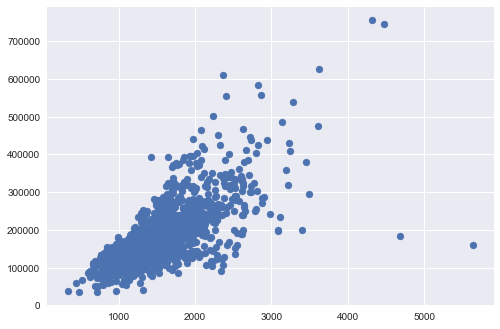

In [57]:
_ = plt.scatter(X["GrLivArea"], df["SalePrice"])

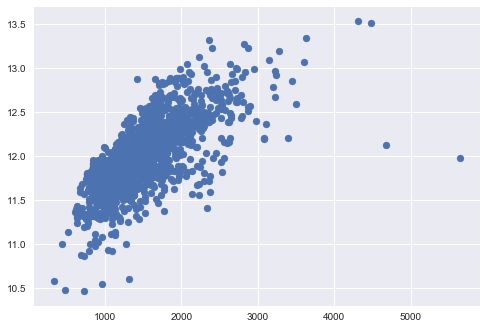

In [58]:
_ = plt.scatter(X["GrLivArea"], y)

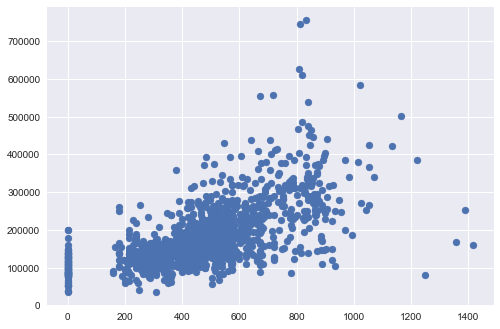

In [59]:
_ = plt.scatter(X["GarageArea"], df["SalePrice"])

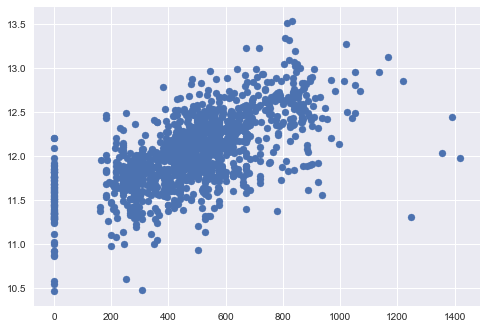

In [60]:
_ = plt.scatter(X["GarageArea"], y)

In [61]:
X = X.values
y = y.values

In [65]:
y = y.reshape((len(y), 1))

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

In [88]:
lin = sm.OLS(X_train, y_train)

In [89]:
res = lin.fit()

In [93]:
print(res.conf_int())

ValueError: shapes (1019,2) and (1019,2) not aligned: 2 (dim 1) != 1019 (dim 0)